In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [40]:
# # assign a data id based on which data you're analysing 

# # import data 
# iris = load_iris(as_frame=True)
# iris_data = iris.data 
# iris_targets = iris.target

# # analyze full data set 
# data_id = "iris_full"

In [41]:
# analyze a subset of the data 
iris = load_iris(as_frame=True)

subset_indices = np.random.choice(range(iris.data.shape[0]), 50, replace=False) #get 50 samples 
iris_data = iris.data.iloc[subset_indices]
iris_targets = iris.target[subset_indices]

data_id = "iris_subset"

## What is the best method to predict the type of iris based on the data? 

### Principal Component Analysis

First we will run a PCA and examine what features contribute the most to each of the principal components 

In [42]:
def do_PCA(dataset): 
    '''returns a trained PCA object and transformed data for the input dataset'''
    pca = PCA()
    trained_pca = pca.fit(dataset)
    fitted_data = pca.transform(dataset)
    return trained_pca, fitted_data

In [43]:
 ## Run PCA on the data set 
iris_pca, iris_pca_data = do_PCA(iris_data)

In [44]:
# scree plot
def scree_plot(pca_object):
    '''
    plots the amount of variance in the data explained by each PC of a PCA and prints the explained variance values

    Parameters: 
        pca_object (sklearn PCA object) : A PCA object that has already been trained on data 
    '''
    per_var = np.round(pca_object.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    fig = plt.figure(figsize=(12, 3))
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot for PCA')
    
    for i in range(len(per_var)): 
        print("Percent of variance explained by PC{}: {}".format(i+1, per_var[i]))

    plt.savefig(data_id + "_scree_plot.png")

Percent of variance explained by PC1: 90.9
Percent of variance explained by PC2: 6.6
Percent of variance explained by PC3: 1.9
Percent of variance explained by PC4: 0.6


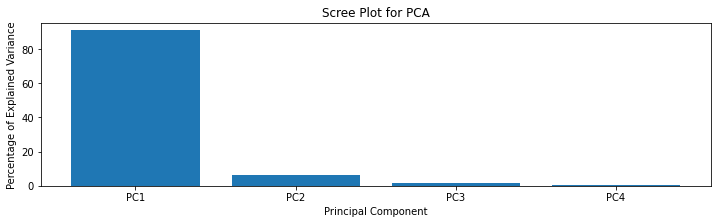

In [45]:
scree_plot(iris_pca)

From this, we can see that the first PC explains the variance in the data very well: 92% of the variance is explained by this PC. 

#### Which variables contributed most to PC1? 

In [46]:
n_features = len(iris_data.columns)
for i in range(n_features):
    print("Contribution of {} to PC1: {}".format(iris_data.columns.values[i], np.around(iris_pca.components_[0][i], 2)))


Contribution of sepal length (cm) to PC1: 0.37
Contribution of sepal width (cm) to PC1: -0.07
Contribution of petal length (cm) to PC1: 0.85
Contribution of petal width (cm) to PC1: 0.37


In [47]:
# visual examination: remake the histogram of petal length colored by type 

def histogram_by_subtype(df, feature_name, subtypes): 
    '''
    Parameters: 
        df (pandas data frame): the data frame to plot
        feature_name (str): feature from dataframe to plot
        subtypes (array) : array, aligned to the dataframe, that contains labels for coloring the           histogram
    '''
    fig = plt.figure()
    fig.suptitle('{} for each subtype of Iris'.format(feature_name))

    for subtype in np.unique(subtypes): 
        plt.hist(df.loc[:, feature_name][subtypes==subtype]) #graph the values for petal length from each subtype 

    plt.savefig(data_id + "histogram.png")
    plt.show()

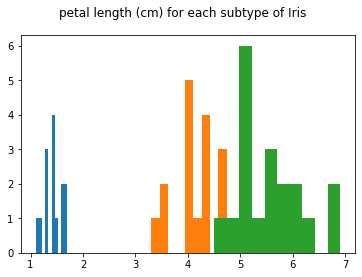

In [48]:
histogram_by_subtype(iris_data, 'petal length (cm)', iris_targets)

Since PC1 explains most of the variance in the data, and "petal length" contributed the most to PC1, I hypothesize that "petal length" may be a good predictor of iris type. The above histogram supports this hypothesis; we can see that the different iris types only overlap a small amount in the histogram. 

### Test the efficacy of different features as a predictor of iris type 

Method: 

1. Apply KMeans clustering to each feature or set of features 

2. Evaluate the goodness of KMeans cluster results against the actual iris subtypes using adjusted rand score. A score of 0 indicates that this clustering was no better than random, and a score of 1 indicates that KMeans perfectly clustered the data by subtype. 

In [49]:
# clear any contents of previous file 
with open(data_id + "kmeans_results.txt", "w") as f: 
    f.write("")

In [50]:
def save_kmeans_and_rand(data, true_labels, features_selected, n_clusters=3): 
    '''clusters the given data using Kmeans clustering and evaluates 
    the quality of the resultant clusters against the actual 
    iris cluster labels using the adjusted rand score. 
    Returns the rand score (0 = bad clustering, 1= perfect clustering)
    '''
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)
    rand = adjusted_rand_score(true_labels, cluster_labels)

    result = "Rand Score for {}: {}".format(features_selected, rand)
    print(result)
    with open(data_id + "_kmeans_results.txt", "a") as f: # append to results file 
        f.write(result)

In [51]:
# quality of clustering based on full iris data set 
save_kmeans_and_rand(iris_data, iris_targets, "all Iris features")

Rand Score for all Iris features: 0.8161327149590876


In [52]:
#quality of clustering based on just petal length
reshaped_petal_length = np.expand_dims(iris_data['petal length (cm)'].values, -1) # reshape bc kmeans clustering expects input with (n_samples, n_features) shape

save_kmeans_and_rand(reshaped_petal_length, iris_targets, "petal length only")

Rand Score for petal length only: 0.8734604096662272


In [53]:
# try clustering using just the first PC from PCA 

reshaped_first_PC = np.expand_dims(iris_pca_data[:, 0], -1) # reshape necessary bc kmeans clustering expects input with (n_samples, n_features) shape

save_kmeans_and_rand(reshaped_first_PC, iris_targets, "first PC")

Rand Score for first PC: 0.8161327149590876
